In [1]:
# Standard library
from pathlib import Path
import sys
import warnings
from datetime import datetime
from zoneinfo import ZoneInfo

# Notebook bootstrap: make repo root importable (src/ lives one level above notebooks/)
REPO_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(REPO_ROOT))

# Third-party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Local
from src.config import PROJECT_ROOT

# Warnings (do not globally silence)
warnings.simplefilter("default")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
sns.set_style("whitegrid")

now = datetime.now(tz=ZoneInfo("Europe/Madrid"))
print(f"CWD: {Path.cwd()}")
print(f"REPO_ROOT (bootstrap): {REPO_ROOT}")
print(f"PROJECT_ROOT (from src.config): {PROJECT_ROOT}")
print(f"Repo markers: src={(PROJECT_ROOT/'src').exists()}, data={(PROJECT_ROOT/'data').exists()}")
print(f"Environment check - pandas: {pd.__version__}, numpy: {np.__version__}")
print(f"Notebook run at: {now.strftime('%Y-%m-%d %H:%M %Z')}")



CWD: c:\Users\migue\Desktop\GIT\spain_river_flooding\notebooks
REPO_ROOT (bootstrap): C:\Users\migue\Desktop\GIT\spain_river_flooding
PROJECT_ROOT (from src.config): C:\Users\migue\Desktop\GIT\spain_river_flooding
Repo markers: src=True, data=True
Environment check - pandas: 3.0.0, numpy: 2.4.2
Notebook run at: 2026-02-17 12:28 CET


# 01 Anuario Data Quality & Structure

## Purpose

Systematic assessment of Anuario de Aforos tables, one section per table.  
For each table:
1. Field description (from Descripcion_def_Tablas.pdf).
2. Schema validation (columns, dtypes, units).
3. Basic profiling (shape, ranges, missing, duplicates).
4. Strengths / weaknesses / risks / mitigation.

**Reference**: Descripcion_def_Tablas.pdf [file:52]

**Scope v0**: Focus on Guadalete-Jerez pilot tables (AFLIQ, ESTAF, ANUALA, EXTREMOS_A/AV).

**Output**: dataprocessed/anuario_table_summary.csv (generated here).

## AFLIQ - Daily River Gauging Stations

### 1. Field Description (from PDF)
- `indroea`: Station ID (integer/string).
- `fecha`: Date (día/mes/año, daily).
- `altura`: Daily mean stage (m).
- `caudal`: Daily mean discharge (m³/s).

**Expected**: Long daily time series per station, official units.

,indroea,fecha,altura,caudal
0,5001,1931-11-17,0.38,NaN
1,5001,1931-11-18,0.34,NaN
2,5001,1931-11-19,0.31,NaN
3,5001,1931-11-20,0.28,NaN
4,5001,1931-11-21,0.26,NaN
5,5001,1931-11-22,0.24,NaN
6,5001,1931-11-23,0.23,NaN
7,5001,1931-11-24,0.22,NaN
8,5001,1931-11-25,0.21,NaN
9,5001,1931-11-26,0.20,NaN


,indroea,fecha,altura,caudal
996564,5088,2001-02-27,0.59,NaN
673108,5062,1957-01-28,NaN,13.000
293859,5025,1970-01-12,0.82,2.020
922304,5081,1995-03-29,0.14,0.395
1274543,5145,1996-03-18,NaN,NaN
374224,5031,1990-12-24,0.03,0.014
744891,5066,1990-11-19,NaN,5.030
317131,5027,1982-01-06,1.58,2.660
442721,5042,1952-07-20,0.09,0.720
619058,5057,1961-12-20,0.19,1.760


shape: (1379290, 4)
columns: ['indroea', 'fecha', 'altura', 'caudal']


indroea            string
fecha      datetime64[us]
altura            float64
caudal            float64
dtype: object

stations: 135
date min: 1912-01-01 00:00:00 date max: 2021-09-30 00:00:00


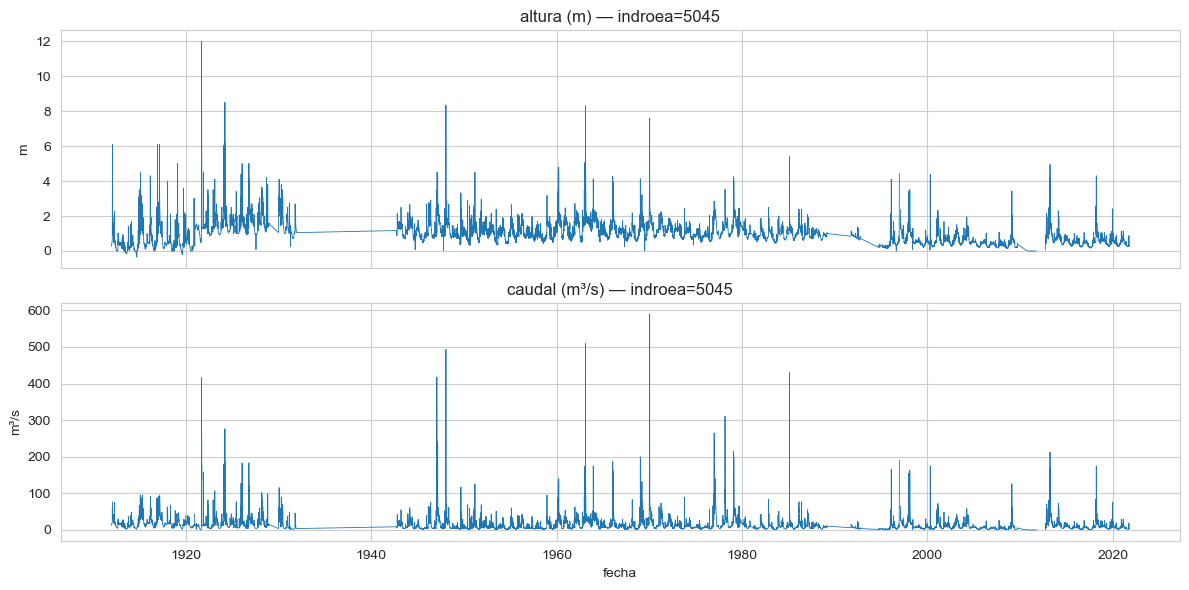

In [3]:
path = PROJECT_ROOT / "data" / "raw" / "GUADALQUIVIR_DATA" / "afliq.csv"  # ajusta si hace falta

df = pd.read_csv(path, sep=";", dtype={"indroea": "string"})
df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors="coerce")
df["altura"] = pd.to_numeric(df["altura"], errors="coerce")
df["caudal"] = pd.to_numeric(df["caudal"], errors="coerce")

# 1) Vista tabular
display(df.head(20))
display(df.sample(20, random_state=0))
print("shape:", df.shape)
print("columns:", list(df.columns))
display(df.dtypes)

# 2) Cobertura temporal y estaciones
print("stations:", df["indroea"].nunique())
print("date min:", df["fecha"].min(), "date max:", df["fecha"].max())

# 3) Gráfico simple para 1 estación (la primera con más filas)
station = df["indroea"].value_counts().index[0]
d = df.loc[df["indroea"] == station].sort_values("fecha")

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(d["fecha"], d["altura"], linewidth=0.6)
ax[0].set_title(f"altura (m) — indroea={station}")
ax[0].set_ylabel("m")

ax[1].plot(d["fecha"], d["caudal"], linewidth=0.6)
ax[1].set_title(f"caudal (m³/s) — indroea={station}")
ax[1].set_ylabel("m³/s")
ax[1].set_xlabel("fecha")

plt.tight_layout()
plt.show()

In [4]:
df["indroea"].value_counts().head(20)

indroea
5045    33669
5029    31207
5047    28889
5004    28726
5012    27112
5001    26186
5025    24852
5077    23884
5065    23293
5019    22696
5039    22055
5023    21966
5002    21547
5003    20760
5057    20480
5042    19671
5070    18533
5072    17144
5140    16923
5063    16801
Name: count, dtype: Int64